In [1]:
from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True )

## DQN

In [3]:
# DQN
class QNetwork(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_actions):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0),-1)    
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)
    
class DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], hidden_dim = 6, USE_CUDA = False):
        self.behaviourNet = QNetwork(in_channels = in_channels, hidden_dim = hidden_dim, num_actions = action_space.n)
        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.behaviourNet = self.behaviourNet.cuda()
        self.behaviourNet = torch.load('saved_model\DQN')

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.behaviourNet(state)
        return q_values
    
    def act(self, state):
        q_values = self.value(state).cpu().detach().numpy()
        aciton = q_values.argmax(1)[0]
        return aciton

In [4]:
env.seed(2021)
Agent = DQNAgent(4, env.action_space, 6, True)
for e in range(10):
    episode_reward = 0
    state = env.reset()
    env.render()
    done = False
    while not done:
        action = Agent.act(Agent.observe(state))
        next_state, reward, done,_ = env.step(action)
        state = next_state
        episode_reward += reward
        env.render()
    print("episode:",e,",reward:",episode_reward)
env.close()

episode: 0 ,reward: 19.0
episode: 1 ,reward: 20.0
episode: 2 ,reward: 19.0
episode: 3 ,reward: 20.0
episode: 4 ,reward: 20.0
episode: 5 ,reward: 20.0
episode: 6 ,reward: 19.0
episode: 7 ,reward: 18.0
episode: 8 ,reward: 19.0
episode: 9 ,reward: 20.0


## DATQN

In [5]:
class QNetwork(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_actions):
        super(QNetwork, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), # bs*32*19*19
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), # bs*64*9*9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # bs*64*7*7
            nn.ReLU()
        )
        self.encoder_linear = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512), # bs*512
            nn.ReLU(),
            nn.Linear(512, hidden_dim), # bs*hid_dim
            nn.ReLU()
        )
        self.DQN = nn.Linear(hidden_dim, num_actions) # bs*num_actions
        self.decoder_linear = nn.Sequential(
            nn.Linear(hidden_dim, 512), # bs*512
            nn.ReLU(),
            nn.Linear(512, 7 * 7 * 64), # bs*64*7*7
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1), # bs*64*9*9
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2), # bs*32*19*19
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=8, stride=4) # bs*4*80*80
        )


    def forward(self, x):
        ## encoder:input->hidden
        hidden = self.encoder_conv(x)
        hidden = hidden.reshape(hidden.size(0),-1)
        hidden = self.encoder_linear(hidden)
        ## DQN:hidden->qtable
        qtable = self.DQN(hidden)
        ## decoder:hidden->output
        output = self.decoder_linear(hidden)
        output = output.reshape(output.size(0),64,7,7)
        output = self.decoder_conv(output)
        
        return qtable, output
    
class DATQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], hidden_dim = 6, USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.behaviourNet = QNetwork(in_channels = in_channels, hidden_dim = hidden_dim, num_actions = action_space.n)
        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.behaviourNet = self.behaviourNet.cuda()
        self.behaviourNet = torch.load('saved_model\DATQN')

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values, _ = self.behaviourNet(state)
        return q_values
    
    def act(self, state):
        q_values = self.value(state).cpu().detach().numpy()
        aciton = q_values.argmax(1)[0]
        return aciton
    
    def reconstruct(self, state):
        _, output = self.behaviourNet(state)
        return output

In [6]:
env.seed(2021)
Agent = DATQNAgent(4, env.action_space, 6, True)
for e in range(10):
    episode_reward = 0
    state = env.reset()
    env.render()
    done = False
    while not done:
        action = Agent.act(Agent.observe(state))
        next_state, reward, done,_ = env.step(action)
        state = next_state
        episode_reward += reward
        env.render()
    print("episode:",e,",reward:",episode_reward)
env.close()

episode: 0 ,reward: 21.0
episode: 1 ,reward: 21.0
episode: 2 ,reward: 21.0
episode: 3 ,reward: 21.0
episode: 4 ,reward: 21.0
episode: 5 ,reward: 21.0
episode: 6 ,reward: 21.0
episode: 7 ,reward: 20.0
episode: 8 ,reward: 21.0
episode: 9 ,reward: 21.0


In [7]:
random.seed(2021)
num = random.randint(0,1000)

frame = env.reset()
for i in range(num):
    action = Agent.act(Agent.observe(frame))
    next_frame, reward, done,_ = env.step(action)
    frame = next_frame
    if done: frame = env.reset()
    
state = Agent.observe(frame)
recon = Agent.reconstruct(state)
state = state.cpu().numpy().squeeze(0)
recon = recon.cpu().detach().numpy().squeeze(0)

In [8]:
state = Agent.observe(frame)
recon = Agent.reconstruct(state)
state = state.cpu().numpy().squeeze(0)
recon = recon.cpu().detach().numpy().squeeze(0)

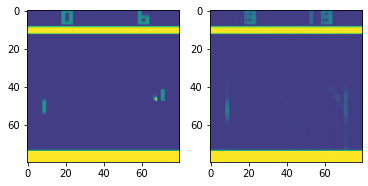

In [9]:
plt.subplot(1,2,1)
plt.imshow(state[0,:,:])
plt.subplot(1,2,2)
plt.imshow(recon[0,:,:])

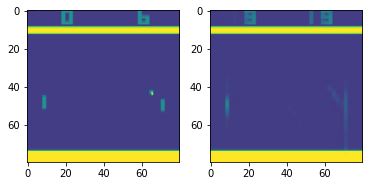

In [10]:
plt.subplot(1,2,1)
plt.imshow(state[1,:,:])
plt.subplot(1,2,2)
plt.imshow(recon[1,:,:])

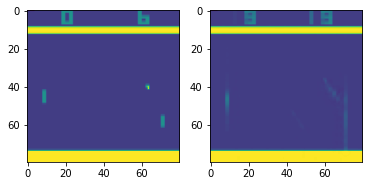

In [11]:
plt.subplot(1,2,1)
plt.imshow(state[2,:,:])
plt.subplot(1,2,2)
plt.imshow(recon[2,:,:])

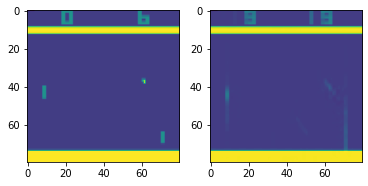

In [12]:
plt.subplot(1,2,1)
plt.imshow(state[3,:,:])
plt.subplot(1,2,2)
plt.imshow(recon[3,:,:])